<a href="https://colab.research.google.com/github/miltiadiss/Lung-cancer-classification-from-CT-images-using-exlainability-methods/blob/main/VGG_%26_tree_based_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **VGG16 with tree-based classifiers**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


oad neccesary packages

In [52]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
import pickle
from sklearn.inspection import permutation_importance
import cv2

Load training, validation and test sets

In [3]:
training_data = np.load("drive/MyDrive/train.npz")
X_train = training_data["X"]
y_train = training_data["y"]

validation_data = np.load("drive/MyDrive/val.npz")
X_val = validation_data["X"]
y_val = validation_data["y"]

test_data = np.load("drive/MyDrive/test.npz")
X_test = test_data["X"]
y_test = test_data["y"]

Use **VGG16** pretrained CNN for **feature extraction**

In [7]:
# Load VGG16 model weights
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# Freeze weights so that it works only as en extractor
for layer in base_model.layers:
    layer.trainable = False

# Add global average pooling to get feature vector
feature_extractor = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D()
])

# Transfrom FROM 1 TO 3 channels (gray --> RGB)
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb = np.repeat(X_val, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Apply preprocessing og VGG16
X_train_prep = preprocess_input(X_train_rgb)
X_val_prep = preprocess_input(X_val_rgb)
X_test_prep = preprocess_input(X_test_rgb)

# Extract feature vectors
train_features = feature_extractor.predict(X_train_prep, batch_size=32, verbose=1)
val_features = feature_extractor.predict(X_val_prep, batch_size=32, verbose=1)
test_features = feature_extractor.predict(X_test_prep, batch_size=32, verbose=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 975s 26s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 139s 23s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 136s 22s/step


Save the extracted features

In [8]:
np.savez("drive/MyDrive/vgg16_features.npz",
         X_train=train_features, y_train=y_train,
         X_val=val_features, y_val=y_val,
         X_test=test_features, y_test=y_test)

Visualize the extracted training features on 2d plane

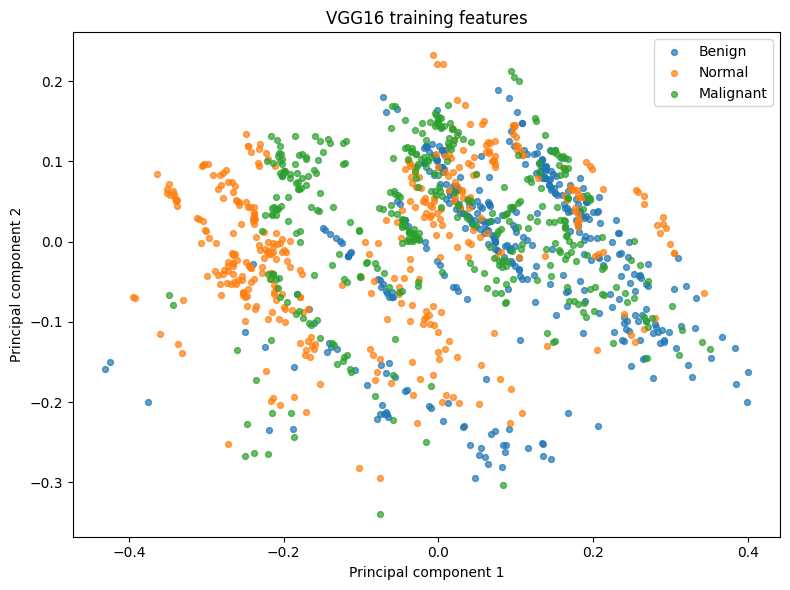

In [26]:
class_mapping = {
  'Benign': 0,
  'Normal': 1,
  'Malignant': 2
}

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# PCA reduction
pca = PCA(n_components=2, random_state=42)
train_pca = pca.fit_transform(train_features)

plt.figure(figsize=(8, 6))
class_names = list(class_mapping.keys())

for i, class_name in enumerate(class_names):
    mask = (y_train == i)
    plt.scatter(train_pca[mask, 0], train_pca[mask, 1],
                s=18, alpha=0.7, label=class_name, color=colors[i])

plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('VGG16 training features')
plt.legend()
plt.tight_layout()
plt.show()

Then apply **tree-based algorithms** for the **classification** of the images



- **Decision tree**

Use Grid Search to locate best hyperparameter combination

In [11]:
# Unify train + val for training/tuning
X_trainval = np.concatenate([train_features, val_features], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)

param_grid = {
    'criterion': ['gini', 'entropy'],      # criterion
    'max_depth': [5, 10, 15, 20, None],    # max tree depth
    'min_samples_split': [2, 5, 10],       # min samples for splitting
    'min_samples_leaf': [1, 2, 4]          # min samples per leaf
}

# Hyperparameter grid Search with cross-validation
grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,            # 5-fold cross-validation
    n_jobs=-1,
    verbose=2
)

grid.fit(X_trainval, y_trainval)

print("Best hyperparameter combination found:")
print(grid.best_params_)
print(f"Best CV accuracy: {grid.best_score_:.4f}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best hyperparameter combination found:
{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV accuracy: 0.9068


In [31]:
# Keep best combination
best_tree = grid.best_estimator_

# Save the model
with open("drive/MyDrive/best_decision_tree_model.pkl", "wb") as f:
    pickle.dump(best_tree, f)

Evaluate on test set and plot classification report, confusion matrix, ROC curves


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81        18
           1       0.99      0.98      0.98        85
           2       0.95      0.95      0.95        62

    accuracy                           0.95       165
   macro avg       0.91      0.92      0.91       165
weighted avg       0.95      0.95      0.95       165



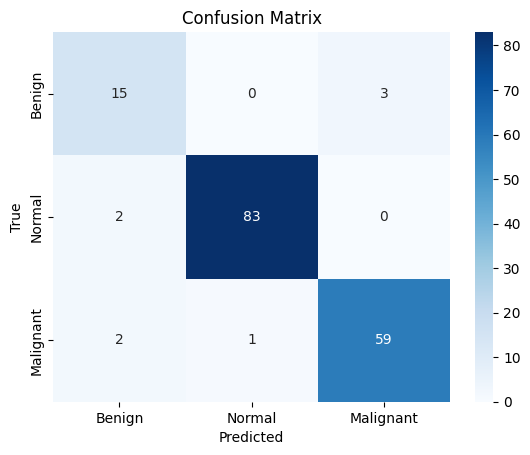

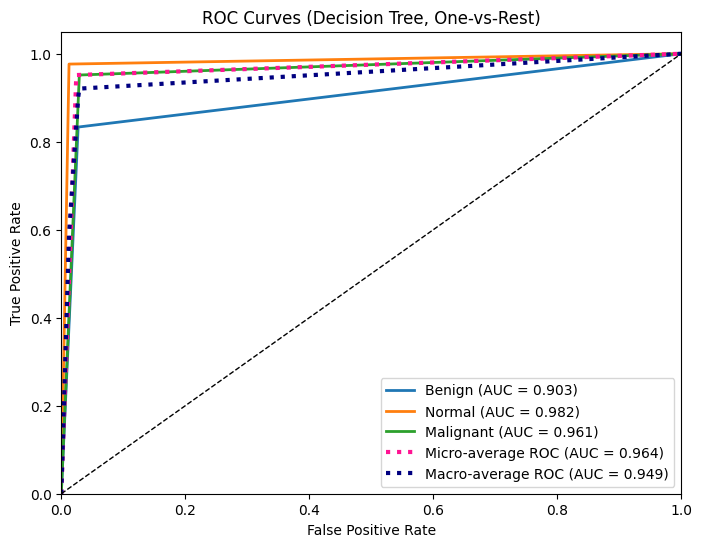

In [24]:
# Evaluate on test set
y_pred = best_tree.predict(test_features)
acc = accuracy_score(y_test, y_pred)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_mapping.keys(),
            yticklabels=class_mapping.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC curves
y_pred_proba = best_tree.predict_proba(test_features)
n_classes = len(class_mapping)
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(8, 6))

for i, (cls, color) in enumerate(zip(class_mapping.keys(), colors)):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{cls} (AUC = {roc_auc[i]:.3f})")

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.3f})',
         color='deeppink', linestyle=':', linewidth=3)
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.3f})',
         color='navy', linestyle=':', linewidth=3)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Decision Tree, One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

- **Random forest**

Use Grid Search to locate best hyperparameter combination

In [17]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],          # tree number
    'criterion': ['gini', 'entropy'],         # criterion
    'max_depth': [10, 20, 30, None],          # max tree depth
    'min_samples_split': [2, 5, 10],          # min samples for splitting
    'min_samples_leaf': [1, 2, 4]             # min samples per leaf
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid_rf,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_rf.fit(X_trainval, y_trainval)

print("Best hyperparameter combination found:")
print(grid_rf.best_params_)
print(f"Best CV accuracy: {grid_rf.best_score_:.4f}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best hyperparameter combination found:
{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV accuracy: 0.9761


In [32]:
# Keep best combination
best_rf = grid_rf.best_estimator_

# Save the model
with open("drive/MyDrive/best_random_forest_model.pkl", "wb") as f:
    pickle.dump(best_rf, f)

Evaluate on test set and plot classification report, confusion matrix, ROC curves


Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.89      0.94        18
      Normal       1.00      0.99      0.99        85
   Malignant       0.95      1.00      0.98        62

    accuracy                           0.98       165
   macro avg       0.98      0.96      0.97       165
weighted avg       0.98      0.98      0.98       165



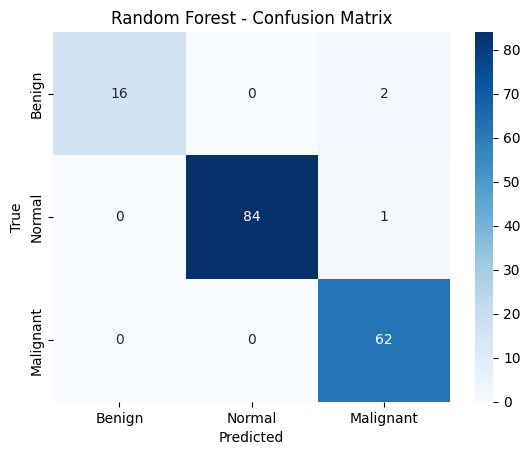

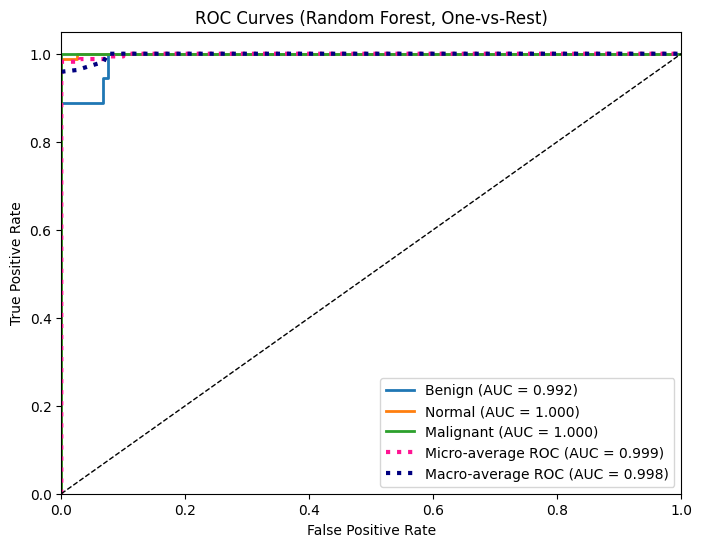

In [25]:
# Evaluate on test set
y_pred = best_rf.predict(test_features)
acc = accuracy_score(y_test, y_pred)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_mapping.keys()))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_mapping.keys(),
            yticklabels=class_mapping.keys())
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curves
y_pred_proba = best_rf.predict_proba(test_features)
n_classes = len(class_mapping)
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(8, 6))

for i, (cls, color) in enumerate(zip(class_mapping.keys(), colors)):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{cls} (AUC = {roc_auc[i]:.3f})")

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.3f})',
         color='deeppink', linestyle=':', linewidth=3)
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.3f})',
         color='navy', linestyle=':', linewidth=3)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Random Forest, One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

- **Gradient boosting**

Use Grid Search to locate best hyperparameter combination

In [ ]:
param_grid_gb = {
    'n_estimators': [100, 200, 300],      # weak learners number
    'learning_rate': [0.01, 0.05, 0.1],   # learning rate
    'max_depth': [3, 5, 7],               # individual tree depth
    'min_samples_split': [2, 5, 10],      # min samples for splitting
    'min_samples_leaf': [1, 2, 4],        # min samples per leaf
    'subsample': [0.8, 1.0]               # sample percentage per boosting round
}

grid_gb = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid_gb,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_gb.fit(X_trainval, y_trainval)

print("Best hyperparameter combination found:")
print(grid_gb.best_params_)
print(f"Best CV accuracy: {grid_gb.best_score_:.4f}")

In [33]:
# Keep best combination
best_gb = grid_gb.best_estimator_

# Save the model
with open("drive/MyDrive/best_gradient_boosting_model.pkl", "wb") as f:
    pickle.dump(best_gb, f)

Evaluate on test set and plot classification report, confusion matrix, ROC curves


Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.89      0.94        18
      Normal       1.00      0.99      0.99        85
   Malignant       0.95      1.00      0.98        62

    accuracy                           0.98       165
   macro avg       0.98      0.96      0.97       165
weighted avg       0.98      0.98      0.98       165



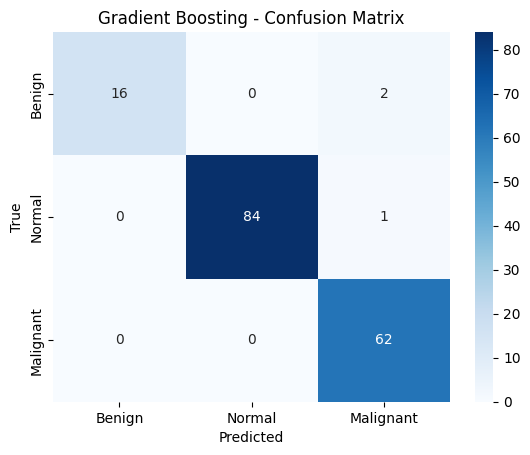

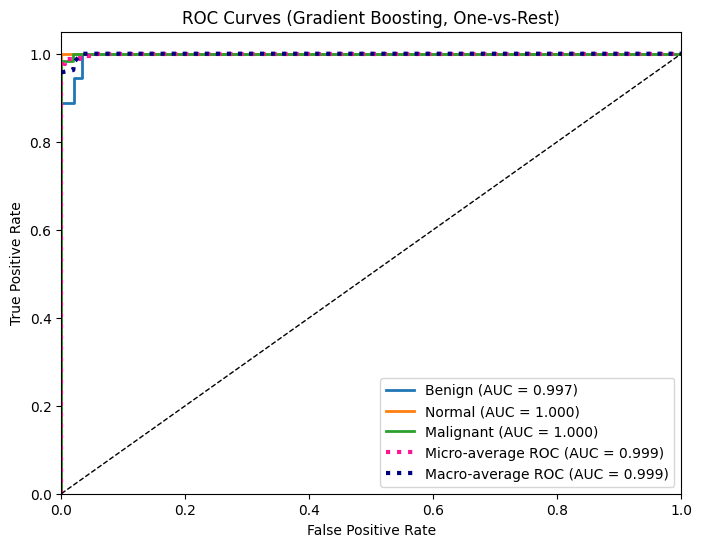

In [38]:
# Evaluate on test set
y_pred = best_gb.predict(test_features)
acc = accuracy_score(y_test, y_pred)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_mapping.keys()))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_mapping.keys(),
            yticklabels=class_mapping.keys())
plt.title("Gradient Boosting - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curves
y_pred_proba = best_gb.predict_proba(test_features)
n_classes = len(class_mapping)
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(8, 6))

for i, (cls, color) in enumerate(zip(class_mapping.keys(), colors)):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{cls} (AUC = {roc_auc[i]:.3f})")

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.3f})',
         color='deeppink', linestyle=':', linewidth=3)
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.3f})',
         color='navy', linestyle=':', linewidth=3)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Gradient Boosting, One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()